$$
\documentclass[a4paper,11pt]{article}
\usepackage[french]{babel}
\usepackage[T1]{fontenc}
\usepackage[utf8]{inputenc}
\usepackage{lmodern}
\usepackage{microtype}
\usepackage{hyperref}
\begin{document}
SALUT LE PROJO
\end{document}
$$

In [1]:
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt

Les fonctions bien pratiques : 

- distance permet de calculer les distances entre deux points a et b

- perpendicular rend la normal à un vecteur (un point en fait) (direction arbitraire)

In [2]:
def distance(a, b) :
    return ((a[0] - b[0])**2 + (a[1]-b[1])**2 ) ** 0.5

def perpendicular( a ) :
    b = np.array([-a[1], a[0]])
    return b


Je définis la fonction contrainte qui impose la distance delta entre deux points du tracé de notre ligne de niveau

In [3]:
def contrainte(a,b,delta):
    return distance(a,b) - delta

La fonction F qui va de R^2 dans R^2, qui lorsqu'elle s'annule :

- vérifie avec sa première coordonnée que le point est bien sur la ligne de niveau f(x,y)=c

- s'assure que le nouveau point créé ,b , est à la distance delta du point précédent de la ligne de niveau, a

Cette fonction permettra par la suite d'utiliser la méthode de newton...

In [4]:
def F(a, b, c, delta, f):
    return np.array([[f(b[0],b[1])-c],[contrainte(a, b, delta)]])

In [5]:
def find_seed(g, c=0, eps = 2**(-26)) :
    # On cherche le réel t tq f(0,t) = c par dichotomie
    a = 0
    b = 1
    if not (g(a) <= c <= g(b) or g(a) >= c >= g(b)) :
        return None
    while b-a > 2*eps :
        t = (b+a) / 2
        if g(t) > c :
            b = t
        elif g(t) < c :
            a = t
        elif g(t) == c :
            return t
    return (b+a) / 2

#NB : Ici la condition "raisonnable" provient du TVI : c compris entre f(0,1) et f(0,0) => t existe

Ici les fonctions gradient et Jacobienne, recopiée directement du poly

In [6]:
def grad_f(f,x,y) :
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]

def Jacob(F, x, y) :
    j = autograd.jacobian
    return np.c_[j(F, 0)(x, y), j(F, 1)(x, y)]

In [7]:
def simple_contour(f, c=0.0, delta=0.001, eps = 2**(-26)) :

    def g(y) :
        return f(0, y)

    if find_seed(g, c) == None :
        return [], []

    X = [0.0]
    Y = [find_seed(g, c)]    # içi le premier point de la ligne de niveau est construit grâce à la dichotomie
    
    perp = perpendicular(grad_f(f, X[0], Y[0]))    #on construit la perpendiculaire au gradient calculé en ce premier point
   
    tg = (perp / np.linalg.norm(perp)) * delta     #la norme du gradient (et donc de la perpendiculaire) étant arbitraire,
                                                   #il fallait la normer, puis la multiplier par delta
    
    
    if tg[0] >= 0 :             # ce test permet de vérifier que la tangeante part bien vers la droite
        X.append(X[0] + tg[0])
        Y.append(Y[0] + tg[1])
    else :
        X.append(X[0] - tg[0])  #si ce n'est pas le cas il suffit d'utiliser l'opposé de notre tangeante.
        Y.append(Y[0] - tg[1])

    while not fin_ligne(X, Y, delta) :
        gradient = grad_f(f, X[-1], Y[-1])
        perp = perpendicular(gradient)
        tg = (perp / np.linalg.norm(perp)) * delta
        adernier = [X[-2], Y[-2]]
        dernier = [X[-1],Y[-1]]
        
        if distance(adernier, dernier + tg) >= distance(adernier, dernier - tg) :
            newton0 = dernier + tg
        else :
            newton0 = dernier - tg
            
        suivant = Newton(f, newton0, dernier, c, delta, eps)
        X.append(suivant[0])
        Y.append(suivant[1])
    
    return X, Y
    # Il reste alors à plotter la ligne de niveau
            
            
def Newton(f, newton0, dernier, c, delta, eps = 2**(-26)) :
    newton_k = newton0
    Fk = F(newton_k, dernier, c, delta, f)
    while Fk[0] > eps and Fk[1] > eps :
        J_inv = np.linalg.inv(Jacob(F, newton_k[0], newton_k[1]))
        newton_k = newton_k - np.dot(J_inv, F(newton_k, dernier, c, delta, f))
    return newton_k
                
def fin_ligne(X, Y, delta) :
    if X[-1] > 1 - delta/2 or X[-1] < delta/2 or Y[-1] > 1 - delta/2 or Y[-1] < delta/2 :
        return True
    if distance([X[0], Y[0]], [X[-1], Y[-1]]) < delta/2 :
        return True
    return False
        



In [8]:
def f(x, y) : # Fonction du poly
    return 2 * (np.exp(-x**2 - y**2) - np.exp(-(x-1)**2 - (y-1)**2))

def Test_jacob(x, y) :
    return np.array([[2*np.exp(x)], [np.exp(y)]])



# Test de la fonction simple_contour :
Si la fonction marche, alors le test devrait nous donner un arc de cercle de rayon 0.8.

**Erreurs rencontrées (et corrigées) grâce à ce test :**
- La fonction ne renvoyait que 2 points et s'arrêtait aussitôt : oubli de rendre le vecteur tangent de norme delta : on sort tout de suit du cadre
- Erreurs de syntaxe et de typage : la fonction gradient n'aime pas les entiers, on a donc initalisé X avec [0.0] plutôt que [0]

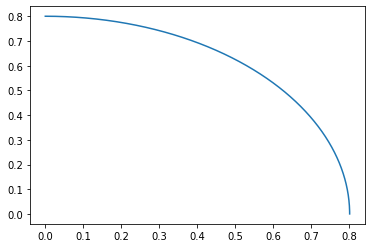

In [9]:
def test_simple(x,y) :
    return x**2 + y**2

les_x, les_y = simple_contour(test_simple, c = 0.64, delta = 0.001)
#print(les_x, les_y)
plt.plot(les_x, les_y)

<function matplotlib.pyplot.show(*args, **kw)>

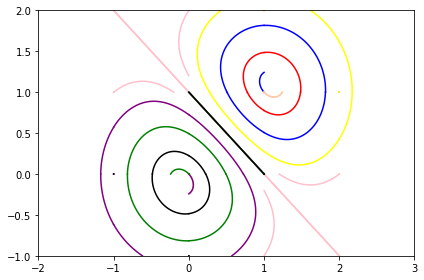

In [13]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[-2.0,-1.0,0.0, 1.0, 2.0, 3.0], ys=[-1.0,0.0, 1.0, 2.0], delta=0.001):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves
colors = ['red','blue','yellow','pink','purple','green','black']
for k in range(1,8):

    level_curves=contour(f, (k-4)/2)

    for x, y in level_curves:
        plt.plot(x, y, c=colors[k-1])
    
plt.axis([-2,3,-1,2])
plt.tight_layout()
plt.show
    